# Task
Load the data from the file "/content/drive/MyDrive/data.csv" into a dataframe and display the first 5 rows and the columns and their types.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve
from imblearn.over_sampling import BorderlineSMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


sns.set(style='whitegrid')

In [ ]:
# Cell 2: Load dan Cek Data
df = pd.read_csv("/content/drive/MyDrive/SKIRPSI BORDERLINE SMOTE + MLP/framingham.csv")
print("Jumlah data sebelum cleaning:", df.shape)
df.dropna(inplace=True)
print("Jumlah data setelah cleaning:", df.shape)
df.head() # Tampilkan 5 baris pertama

Jumlah data sebelum cleaning: (4240, 16)
Jumlah data setelah cleaning: (3658, 16)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [ ]:
# Cell 3: One-Hot Encoding dan Konversi Tipe
df['education'] = df['education'].astype(int)
df = pd.get_dummies(df, columns=['education'], prefix='edu')

In [ ]:
# Cell 4: Pilih Fitur Terbaik (Kombinasi Baru)
selected_features = ['age', 'BMI', 'glucose', 'currentSmoker', 'sysBP', 'heartRate', 'diabetes']
X = df[selected_features]
y = df['TenYearCHD'].astype(int)

In [ ]:
# Cell 5: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Cell 6: Split Data Latih & Uji
X_train, X_test, y_train, y_test = train_test_split(
X_scaled, y, test_size=0.2, random_state=42, stratify=y)


print("Distribusi kelas sebelum SMOTE:")
print(y_train.value_counts())

Distribusi kelas sebelum SMOTE:
TenYearCHD
0    2480
1     446
Name: count, dtype: int64


In [ ]:
# Cell 7: Terapkan Borderline SMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)


print("Distribusi kelas setelah Borderline SMOTE:")
print(y_train_bal.value_counts())

Distribusi kelas setelah Borderline SMOTE:
TenYearCHD
0    2480
1    2480
Name: count, dtype: int64


In [ ]:
# Cell 8: Bangun Arsitektur MLP Baru
def build_optimized_mlp(input_dim):
    model = Sequential(name="Optimized_MLP")
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))


    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))


    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))


    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Cell 9: Training Model Usulan
model_usulan = build_optimized_mlp(X_train_bal.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model_usulan.fit(
X_train_bal, y_train_bal,
validation_split=0.2,
epochs=100,
batch_size=32,
callbacks=[early_stop],
verbose=0
)

In [ ]:
# Cell 10: Threshold Tuning - Cari Threshold Terbaik
y_pred_proba = model_usulan.predict(X_test)
thresholds = np.arange(0.1, 0.9, 0.01)


scores = []
for t in thresholds:
    y_pred = (y_pred_proba > t).astype(int)
    acc = accuracy_score(y_test, y_pred)
    scores.append((t, acc))


best_threshold = max(scores, key=lambda x: x[1])[0]
print(f"Threshold terbaik berdasarkan akurasi: {best_threshold:.2f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Threshold terbaik berdasarkan akurasi: 0.76


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

--- Evaluasi: Model Usulan (Optimized + BorderlineSMOTE) ---
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       621
           1       0.60      0.05      0.10       111

    accuracy                           0.85       732
   macro avg       0.73      0.52      0.51       732
weighted avg       0.82      0.85      0.79       732



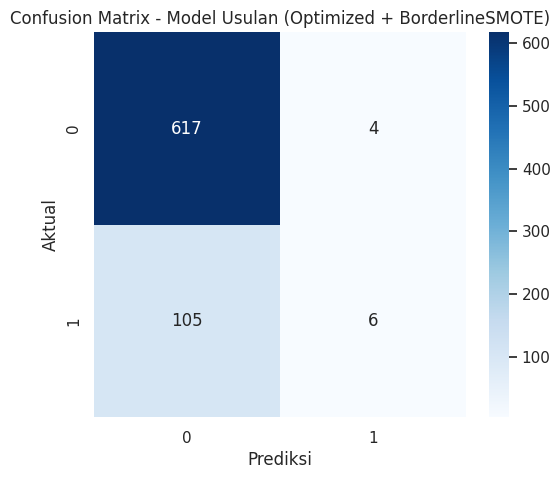

In [ ]:
# Cell 11: Evaluasi Model Usulan dengan Threshold Terbaik
def evaluate_model_with_threshold(model, X_test, y_test, threshold, model_name):
    y_proba = model.predict(X_test)
    y_pred = (y_proba > threshold).astype(int)


    print("\n--- Evaluasi:", model_name, "---")
    print(classification_report(y_test, y_pred))


    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Prediksi")
    plt.ylabel("Aktual")
    plt.show()


    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }


metrics_usulan = evaluate_model_with_threshold(
    model_usulan, X_test, y_test, best_threshold, "Model Usulan (Optimized + BorderlineSMOTE)")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

--- Evaluasi: Model Baseline (Tanpa SMOTE) ---
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       621
           1       0.38      0.05      0.08       111

    accuracy                           0.84       732
   macro avg       0.62      0.52      0.50       732
weighted avg       0.78      0.84      0.79       732



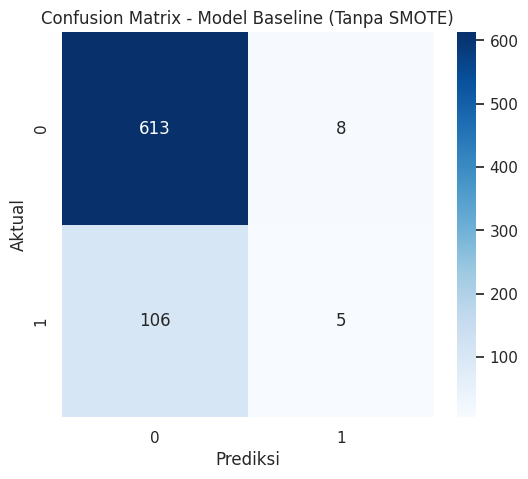

In [ ]:
# Cell 12: Buat Model Baseline (Tanpa SMOTE)
def build_baseline_mlp(input_dim):
    model = Sequential(name="Baseline_MLP")
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


model_baseline = build_baseline_mlp(X_train.shape[1])
model_baseline.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
metrics_baseline = evaluate_model_with_threshold(
    model_baseline, X_test, y_test, 0.5, "Model Baseline (Tanpa SMOTE)")


--- Perbandingan Kinerja Model ---


,Accuracy,Precision,Recall,F1-Score
Model,,,,
Model Baseline (Tanpa SMOTE),0.844262,0.384615,0.045045,0.080645
Model Usulan (Optimized + BorderlineSMOTE),0.851093,0.600000,0.054054,0.099174


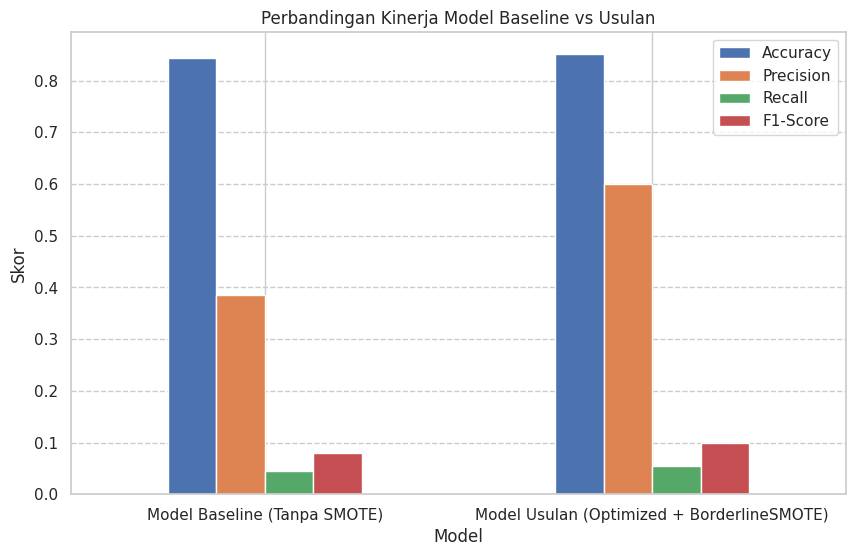

In [ ]:
# Cell 13: Bandingkan Model
comparison_df = pd.DataFrame([metrics_baseline, metrics_usulan]).set_index("Model")
print("\n--- Perbandingan Kinerja Model ---")
display(comparison_df)


comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title("Perbandingan Kinerja Model Baseline vs Usulan")
plt.ylabel("Skor")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()